In [1]:
# Librerias necesarias para modelo de regresión logística
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import os
import time 
import json
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
import os
import pandas as pd

# Ruta base
BASE_PATH = "../data/processed/Excels/"

# Definir las rutas de los archivos de entrenamiento y prueba
TRAIN_PATHS = [
    "X_train_con_outliers.xlsx",
    "X_train_sin_outliers.xlsx",
    "X_train_sel_k4.xlsx"
]

TEST_PATHS = [
    "X_test_con_outliers.xlsx",
    "X_test_sin_outliers.xlsx",
    "X_test_sel_k4.xlsx"
]

# Leer los datasets de entrenamiento
TRAIN_DATASETS = [pd.read_excel(os.path.join(BASE_PATH, path)) for path in TRAIN_PATHS]  # X_train 

# Leer los datasets de prueba
TEST_DATASETS = [pd.read_excel(os.path.join(BASE_PATH, path)) for path in TEST_PATHS]  # X_test

# Leer las etiquetas (target) de entrenamiento y prueba
y_train = pd.read_excel(os.path.join(BASE_PATH, "y_train.xlsx")).values.ravel()
y_test = pd.read_excel(os.path.join(BASE_PATH, "y_test.xlsx")).values.ravel()

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Le pasamos los train y los test al modelo , lo entrenamos y metemos los resultados del test en una lista para poder comparar y escoger el mejor. 

results = []

for index, dataset in enumerate(TRAIN_DATASETS):
    print(index)
    model = DecisionTreeClassifier(random_state = 95 )
    model.fit(dataset, y_train)
    y_pred_train = model.predict(dataset)
    y_pred_test = model.predict(TEST_DATASETS[index])

    results.append(
        {
            "train": accuracy_score(y_train, y_pred_train),
            "test": accuracy_score(y_test, y_pred_test)
        }
    )

results

0
1
2


[{'train': 1.0, 'test': 0.7142857142857143},
 {'train': 1.0, 'test': 0.7142857142857143},
 {'train': 1.0, 'test': 0.7012987012987013}]

In [4]:
# Optimización del modelo. 

best_dataset = 0 # Porque de results, el mayor acuracy en train y test.

# Ponemos los hyperparametros según la documentación.  

hyperparams = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'ccp_alpha': [0.0, 0.01, 0.1, 1.0]
}


from sklearn.model_selection import GridSearchCV 

model = DecisionTreeClassifier(random_state = 95) # Volvemos a seleccionar el modelo sin entrenar. 
grid = GridSearchCV(model, hyperparams, scoring = "accuracy") # Metemos en el gris los nuevos hyperparametros

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# Establecer el dataset con el mejor desempeño
best_dataset = 0  # Índice del dataset con mejor desempeño

# Hiperparámetros reducidos para hacer pruebas más rápidas
hyperparams = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 'sqrt'],
    'max_leaf_nodes': [None, 10],
    'min_impurity_decrease': [0.0, 0.01],
    'ccp_alpha': [0.0, 0.01]
}

# Crear el modelo de árbol de decisión sin entrenar
model = DecisionTreeClassifier(random_state=95)

# Crear el GridSearchCV con menos combinaciones y cv reducido
grid = GridSearchCV(model, hyperparams, scoring="accuracy", cv=3, n_jobs=-1)

# Crear la barra de progreso tqdm para un solo paso de fitting
with tqdm(total=1, desc="Entrenando modelo", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [Tiempo: {elapsed}]") as pbar:
    # Entrenamos el modelo con los nuevos parámetros
    grid.fit(TRAIN_DATASETS[best_dataset], y_train)
    pbar.update(1)  # Actualiza la barra de progreso una vez que el entrenamiento haya terminado

# Obtener los mejores parámetros encontrados por GridSearchCV
best_params = grid.best_params_

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados por GridSearchCV:")
print(best_params)


Entrenando modelo: 100%|██████████| 1/1 [Tiempo: 00:05]

Mejores parámetros encontrados por GridSearchCV:
{'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


In [7]:
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=5,
                       max_features='sqrt', random_state=95)

In [8]:
# Predecimos con el nuevo modelo ya entrenado por los unevos parametros.  

final_model = grid.best_estimator_
y_pred_train = final_model.predict(TRAIN_DATASETS[best_dataset])
y_pred_test = final_model.predict(TEST_DATASETS[best_dataset])

In [9]:
score_train = accuracy_score(y_train, y_pred_train),
score_test = accuracy_score(y_test, y_pred_test)

print(f'Score train: {score_train}')
print(f'Score test: {score_test}')

Score train: (0.7736156351791531,)
Score test: 0.7857142857142857


In [10]:
#Feature selection 

best_dataset = 2 # Porque de results, el mayor acuracy despues de hacer feature selection en train y test.

# Ponemos los hyperparametros según la documentación.  

hyperparams = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'ccp_alpha': [0.0, 0.01, 0.1, 1.0]
}


from sklearn.model_selection import GridSearchCV 

model = DecisionTreeClassifier(random_state = 95) # Volvemos a seleccionar el modelo sin entrenar. 
grid = GridSearchCV(model, hyperparams, scoring = "accuracy") # Metemos en el gris los nuevos hyperparametros

In [11]:
# Entrenamos el modelo con los nuevos parametros. 

grid.fit(TRAIN_DATASETS[best_dataset], y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=95),
             param_grid={'ccp_alpha': [0.0, 0.01, 0.1, 1.0],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 10, 20, 50],
                         'max_features': [None, 'sqrt', 'log2'],
                         'max_leaf_nodes': [None, 10, 20, 50, 100],
                         'min_impurity_decrease': [0.0, 0.01, 0.1],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [12]:
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=10,
                       random_state=95, splitter='random')

In [13]:
# Predecimos con el nuevo modelo ya entrenado por los unevos parametros.  

final_model = grid.best_estimator_
y_pred_train = final_model.predict(TRAIN_DATASETS[best_dataset])
y_pred_test = final_model.predict(TEST_DATASETS[best_dataset])

In [14]:
score_train = accuracy_score(y_train, y_pred_train),
score_test = accuracy_score(y_test, y_pred_test)

print(f'Score train: {score_train}')
print(f'Score test: {score_test}')

Score train: (0.755700325732899,)
Score test: 0.7207792207792207


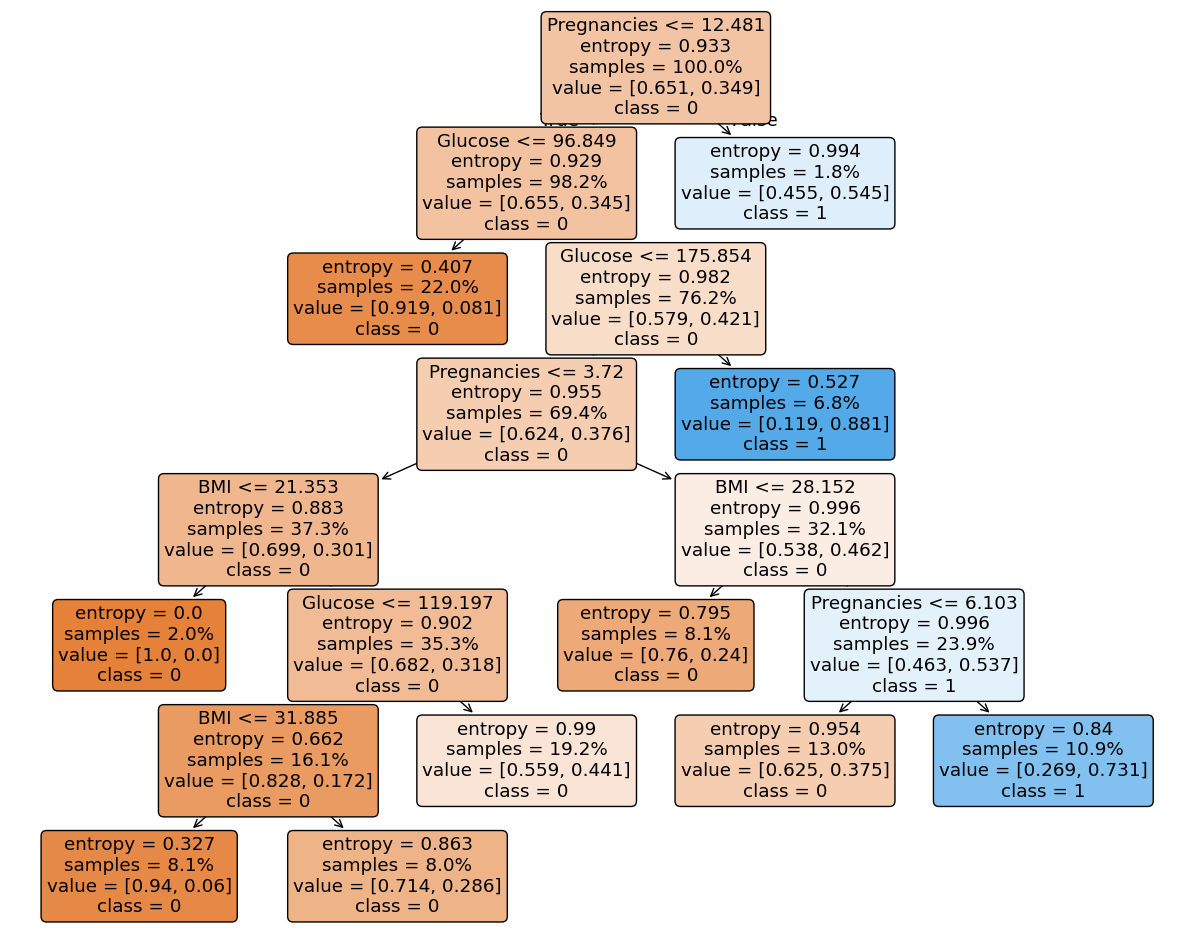

In [15]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

final_model = grid.best_estimator_
column_names = TRAIN_DATASETS[best_dataset].columns.tolist()

plt.figure(figsize=(15, 12)) 
plot_tree(final_model, 
          filled = True,  # Colorea los nodos según la clase predicha
          feature_names = column_names,  # Nombres de tus variables predictoras
          class_names = ['0', '1'],  # Nombres de tus clases (target)
          rounded = True,  # Hacer los bordes de los nodos redondeados
          proportion = True)  # Escalar el gráfico de manera que se ajuste mejor
plt.show()